In [58]:
import pandas as pd
import numpy as np
import random as rand
import importlib 
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
raw = pd.read_csv("yellow-taxis/1january.csv")

In [3]:
# delete unused columns
# del raw['trip_distance']
del raw['passenger_count']
del raw['fare_amount']
del raw['tolls_amount']
del raw['taxes_amount']
del raw['tip_amount']
# del raw['payment_amount']
del raw['payment_type']

In [10]:
# convert pickup_dtatetime to datetime
raw["pickup_datetime"] = pd.to_datetime(raw["pickup_datetime"])
raw["dropoff_datetime"] = pd.to_datetime(raw["dropoff_datetime"])
raw = raw[(raw["pickup_longitude"] > -80) & (raw["pickup_longitude"] < -60)
            & (raw["dropoff_longitude"] > -80) & (raw["dropoff_longitude"] < -60)
            & (raw["pickup_latitude"] > 30) & (raw["pickup_latitude"] < 50)
            & (raw["dropoff_latitude"] > 30) & (raw["dropoff_latitude"] < 50)]
raw = raw.sample(frac=1)
raw = raw.reset_index(drop=True)
raw

,pickup_datetime,pickup_latitude,pickup_longitude,trip_distance,dropoff_datetime,dropoff_latitude,dropoff_longitude,payment_amount
0,2016-01-02 18:13:18,40.75233,-73.97710,2.05,2016-01-02 18:33:23,40.77004,-73.98237,14.30
1,2016-01-18 08:45:29,40.71973,-73.99872,1.93,2016-01-18 08:56:28,40.73822,-74.00805,12.36
2,2016-01-10 03:36:29,40.76048,-73.98725,4.70,2016-01-10 03:57:45,40.70245,-74.01407,18.30
3,2016-01-28 23:29:23,40.75697,-73.96168,3.56,2016-01-28 23:44:01,40.74331,-73.92069,15.30
4,2016-01-17 20:12:35,40.64283,-73.78915,17.70,2016-01-17 20:55:37,40.76253,-73.97817,58.34
5,2016-01-17 21:54:10,40.73665,-74.00578,2.30,2016-01-17 22:06:15,40.76621,-73.98579,14.75
6,2016-01-22 07:49:40,40.76035,-73.96127,2.60,2016-01-22 08:06:31,40.78632,-73.96852,15.30
7,2016-01-25 14:27:44,40.76098,-73.98428,0.50,2016-01-25 14:35:43,40.76659,-73.98660,9.30
8,2016-01-08 18:14:23,40.78378,-73.95473,1.90,2016-01-08 18:27:52,40.75800,-73.97358,12.80
9,2016-01-27 09:06:59,40.79355,-73.96712,0.80,2016-01-27 09:11:38,40.80367,-73.96328,5.80


In [ ]:
#make sure types are okay
print(list(raw.columns.values))
print([raw[i].dtype for i in list(raw.columns.values)])

In [6]:
#convert it to a numpy matrix
#np_raw = raw.as_matrix()

In [7]:
#print(np_raw.dtype)
print(raw.ix[0])
print(len(raw))

pickup_datetime      2016-01-01 00:00:00
pickup_latitude                  40.7347
pickup_longitude                -73.9904
trip_distance                        1.1
dropoff_datetime     2016-01-01 00:00:00
dropoff_latitude                 40.7324
dropoff_longitude               -73.9818
payment_amount                       8.8
Name: 0, dtype: object
10906858


In [63]:
import State as State
importlib.reload(State)        

class MarkovChain:
    # num centers are we picking for k-means
    def __init__(self, raw, k, epsilon = 1e-12):
        self.state_set = set()
        self.id_to_state = {}
        self.adj_matrix = None
        self.raw = raw
        
        self.initialize_centers(k)
        
        self.build_states_kmeans(1000, epsilon)
        
        self.add_points_edges()
        self.make_adjacency_matrix()
    
    def initialize_centers(self, k):
        ind = [i for i in range(len(self.raw))]
#         rand.shuffle(ind)
        centers = ind[:k]
        # initialize centers
        ident = 0
        for c_ind in centers:
            # out of convenience, we aren't messing with pickup lat lon
            lat = self.raw.ix[c_ind]["dropoff_latitude"]
            lon = self.raw.ix[c_ind]["dropoff_longitude"]
            s = State.State((lat, lon), ident)
            self.state_set.add(s)
            self.id_to_state[ident] = s
            ident += 1
    
    def build_states_kmeans(self, iterations, epsilon):
        # run kmeans algorithm
        min_diff = 1e6
        while iterations > 0 and min_diff > epsilon:
            for ind, row in self.raw.iterrows():
                pos_start, pos_end = self.row_to_positions(row)
                closest_to_start = self.find_closest_state(pos_start)
                closest_to_end = self.find_closest_state(pos_end)
                
                closest_to_start.add_position(pos_start)
                closest_to_end.add_position(pos_end)
            max_diff = 0
            for s in self.state_set:
                max_diff = max(max_diff, s.update_center())
            min_diff = min(min_diff, max_diff)
            iterations -= 1 

    def add_points_edges(self):
        for s in self.state_set:
            s.clear_stored_data()
        for ind, row in self.raw.iterrows():
            pos_start, pos_end = self.row_to_positions(row)
            closest_to_start = self.find_closest_state(pos_start)
            closest_to_end = self.find_closest_state(pos_end)
            
            fare = self.row_to_fare(row)
            duration = self.row_to_trip_duration_seconds(row)
            tdistance = self.row_to_distance(row)
            
            #Add points to respective states
            closest_to_start.store_data(pos_start)
            closest_to_end.store_data(pos_end)
            
            ##Add this edge to markov state
            closest_to_start.add_destination(closest_to_end.id, fare, duration)
    
    
    def make_adjacency_matrix(self):
        self.adj_matrix = np.ndarray(shape=(len(self.state_set), len(self.state_set)), dtype=float, order='C')
        for i in sorted(self.id_to_state.keys()):
            for j in sorted(self.id_to_state.keys()):
                self.adj_matrix[i][j] = self.transition_probability(i, j)
    
    def sum_of_square_error(self):
        total = 0
        for s in self.state_set:
            total += s.sum_of_squared_errors
        return total
    
    
#     def random_walk_given_time_cap(self, start_id, duration_cap):
#         while 
    
    def random_walk(self, start_id, walk_length):
        total_duration = 0
        total_fare = 0
        states_visited = []
        next_id = start_id
        for i in range(walk_length):
            states_visited.append(next_id)
            s = self.get_state(next_id)
            next_id, fare, duration = s.next_state()
            total_fare += fare
            total_duration += duration
        return states_visited, total_fare, total_duration
            
    def traveling_salesman(self, start_id):
        total_duration = 0
        total_fare = 0
        states_visited = []
        next_id = start_id
        need_to_visit = set(self.id_to_state.keys()[:])
        need_to_visit.remove(start_id)
        while(len(need_to_visit)):
            states_visited.append(next_id)
            s = self.get_state(next_id)
            next_id, fare, duration = s.next_state()
            total_fare += fare
            total_duration += duration
            need_to_visit.remove(next_id)
        return states_visited, total_fare, total_duration
    
    ##
    # GETTERS
    ##
    def get_invariant(self):
        adjm = m.get_adjacency_matrix()
        S, U = np.linalg.eig(adjm.T)
        inv_dist = U.T[0]
        norm_inv_dist = inv_dist / float(sum(inv_dist))
        return norm_inv_dist
    
    def get_state(self, iden):
        return self.id_to_state(iden)
    
    def get_state_set(self):
        return self.state_set
    
    def get_adjacency_matrix(self):
        return self.adj_matrix
    
    ###
    # HELPER METHODS
    ###
    def find_closest_state(self, pos):
        def distance(state, pos):
            clat, clon = state.center
            return ((clat - pos[0])**2 + (clon - pos[1])**2)**0.5
        closest = None
        min_dist = None
        for state in self.state_set:
            d = distance(state, pos)
            if closest == None or d < min_dist:
                closest = state
                min_dist = d
        return closest
    
    def row_to_positions(self, row):
        lats = row["pickup_latitude"]
        lons = row["pickup_longitude"]
        pos_start = (lats, lons)

        late = row["dropoff_latitude"]
        lone = row["dropoff_longitude"]
        pos_end = (late, lone)
        
        return pos_start, pos_end
    
    def row_to_fare(self, row):
        return row["payment_amount"]
    def row_to_distance(self, row):
        return row["trip_distance"]
    def row_to_trip_duration_seconds(self, row):
        diff = row["pickup_datetime"] - row["dropoff_datetime"]
        return diff.total_seconds()
        
    
    def transition_probability(self, i, j):
        return self.id_to_state[i].probability_to(j)


In [64]:
def find_optimal_k(raw, k_list):
    x = []
    y = []
    k_dict = {}
    for k in k_list:
        print("k: " + str(k))
        if k not in k_dict:
            k_dict[k] = []
        try:
            m = MarkovChain(raw, k)
            x.append(k)
#             y.append()
#             total.append((k, m.sum_of_square_error()))
            y.append(m.sum_of_square_error())
        except ZeroDivisionError:
            print("hello")
    return x, y

In [ ]:
k_list=[i for i in range(5, 50)]
def find_optimal_k_simulator(raw, k_list, num_iter):
    all_points = []
    for i in range(num_iter):
        print("iter: " + str(i))
        raw = raw.sample(frac=1)
        raw = raw.reset_index(drop=True)
        x, y = find_optimal_k(raw, k_list)
        all_points.append((x, y))
    return all_points

start = datetime.datetime.now()
all_points = find_optimal_k_simulator(raw[:1000], [i for i in range(5, 50)], 20)
end = datetime.datetime.now()
print(start - end)

# x, y = find_optimal_k(raw, k_list=[i for i in range(5, 50)])

iter: 0
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34
k: 35
k: 36
k: 37
k: 38
k: 39
k: 40
k: 41
k: 42
k: 43
k: 44
k: 45
k: 46
k: 47
k: 48
k: 49
iter: 1
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34
k: 35
k: 36
k: 37
k: 38
k: 39
k: 40
k: 41
k: 42
k: 43
k: 44
hello
k: 45
hello
k: 46
k: 47
k: 48
k: 49
iter: 2
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34
k: 35
k: 36
k: 37
k: 38
k: 39
k: 40
k: 41
k: 42
k: 43
k: 44
k: 45
k: 46
k: 47
k: 48
k: 49
iter: 3
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 3

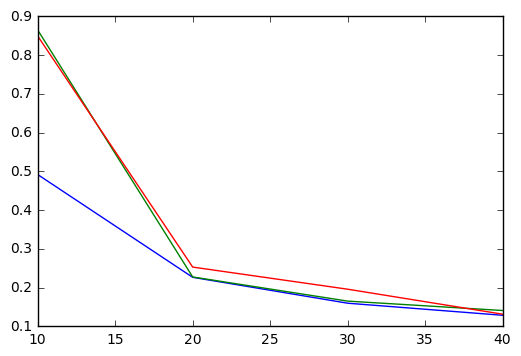

In [66]:
for pt in all_points:
    plt.plot(pt[0], pt[1])
# plt.plot(x, y)

In [55]:
print(all_points[0])

([10, 20, 30, 40], [0.49201334122094553, 0.22677217989418863, 0.1599645005620641, 0.12878483732713636])


In [14]:
m = MarkovChain(raw[:1000], 10)

1000


In [15]:
adjm = m.get_adjacency_matrix()

In [16]:
np.sum(adjm, axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [17]:
S, U = np.linalg.eig(adjm.T)

In [18]:
print(U.T)

[[ 0.21961368+0.j          0.02158666+0.j          0.40592626+0.j
   0.41247066+0.j          0.38306251+0.j          0.31325192+0.j
   0.04437547+0.j          0.19905242+0.j          0.56188841+0.j
   0.11925767+0.j        ]
 [ 0.18582019+0.j          0.01524225+0.j          0.19906090+0.j
   0.16117633+0.j         -0.21815715+0.j          0.10685205+0.j
   0.03124029+0.j         -0.84891247+0.j          0.34415696+0.j
   0.02352065+0.j        ]
 [ 0.42793768+0.j          0.02921938+0.j         -0.21532202+0.j
   0.44003177+0.j         -0.49795249+0.j         -0.35948638+0.j
   0.00606346+0.j          0.09443276+0.j          0.34336826+0.j
  -0.26829243+0.j        ]
 [-0.39385122+0.j         -0.01088500+0.j          0.48961556+0.j
   0.28128472+0.j         -0.33739251+0.j         -0.08916013+0.j
  -0.02280277+0.j          0.00351517+0.j          0.48729119+0.j
  -0.40761500+0.j        ]
 [ 0.18914476+0.j          0.02348789+0.j          0.72152364+0.j
  -0.57546506+0.j         -0.06218

In [19]:
# U is row major
inv_dist = U.T[0]
print(inv_dist)

[ 0.21961368+0.j  0.02158666+0.j  0.40592626+0.j  0.41247066+0.j
  0.38306251+0.j  0.31325192+0.j  0.04437547+0.j  0.19905242+0.j
  0.56188841+0.j  0.11925767+0.j]


In [20]:
norm_inv_dist = inv_dist / float(sum(inv_dist))

/Users/cheng/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


In [21]:
inv2 = sorted(norm_inv_dist)

In [22]:
old_norm_inv_dist = sorted(norm_inv_dist)

In [23]:
old_norm_inv_dist

[(0.0080532653244771244+0j),
 (0.016555012354487846+0j),
 (0.044491068047511385+0j),
 (0.074259832583235805+0j),
 (0.081930557658552478+0j),
 (0.11686386682568151+0j),
 (0.14290787584805914+0j),
 (0.15143757774408342+0j),
 (0.15387907577152418+0j),
 (0.20962186784238698+0j)]